In [1]:
from utils import runwrite

# data/synthetic.py

In [2]:
%%runwrite ../timegym/data/synthetic.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gluonts.dataset.artificial import recipe as rcp
from sktime.forecasting.model_selection import temporal_train_test_split

The oracle is the ideal prediction:

1. In the case of a point forecasting, the oracle is the true mean.
2. In the case of probabilistic forecasting, the oracle is the true distribution.

In [3]:
%%runwrite -a ../timegym/data/synthetic.py

class SyntheticSeries:
    def __init__(self, length, test_size, shortname=None):
        """
        TODO function description
        """
        self.length = length
        self.test_size = test_size
        self.target = self.shortname = shortname 
        self.components = self.generate_components()
        if shortname is None: self.target = self.shortname = self.components.columns[-1]
    
    
    def generate_components(self):
        """
        TODO function description
        """
        raise NotImplementedError
    
    
    def get_data(self, generate_new=True, include_oracle=True):
        """
        TODO function description
        """
        if generate_new: 
            self.components = self.generate_components()
        y_train, y_test = temporal_train_test_split(self.components[self.target], test_size=self.test_size)
        if include_oracle:
            return y_train, y_test, self.components['oracle']
        else: 
            return y_train, y_test
    
    
    def plot_timeseries(self, **kwargs):
        """
        TODO function description
        """
        ax = self.components['oracle'].plot(marker="o",  markersize=5, **kwargs)
        self.components[self.target].plot(ax=ax, linewidth=2)
        return ax
    
    
    def plot_components(self, 
                        oracle_on_target=True, 
                        bins_size=20, 
                        histogram_components=['target', 'noise'], 
                        scatter_components=['target', 'noise'],
                        show_title=False):
        """
        TODO function description
        """
        fig, axes = plt.subplots(nrows=self.components.shape[1], squeeze=False, 
                                 figsize=(20, 3*self.components.shape[1]))
        if show_title:
            fig.suptitle(self.target, fontsize=14)
        
        histogram_components = [self.target if c=='target' else c for c in histogram_components]
        scatter_components = [self.target if c=='target' else c for c in scatter_components]
        for ax, label in zip(axes[:, 0], self.components):
            if label in histogram_components:
                ax.hist(self.components[label], bins=self.length//bins_size,
                        orientation="horizontal", color='#3333FF55')
            if label in scatter_components:
                ax.scatter(x=range(self.components.shape[0]), 
                           y=self.components[label], s=5)
            else:
                self.components[label].plot(ax=ax, linewidth=2)
            ax.set_xlim(xmin=0)
            ax.grid(False)
            ax.set_ylabel(label)
        
        if oracle_on_target: 
            self.components.oracle.plot(ax=axes[-1, 0], linewidth=1)

        return axes

In [4]:
%%runwrite -a ../timegym/data/synthetic.py

class GluonSyntheticSeries(SyntheticSeries):
    def __init__(self, length, test_size, **recipe):
        """
        TODO function description
        """
        self.recipe = recipe
        self.gluonts_recipe = [(label, recipe[label]) for label in recipe]
        super().__init__(length, test_size, self.gluonts_recipe[-1][0])
    
    def generate_components(self):
        """
        TODO function description
        """
        # generates a dataframe, with timeseries components
        # the last two columns should be the oracle and the final timeseries
        components = rcp.evaluate(self.gluonts_recipe, self.length)
        for label in components:
            if components[label].shape[0] == 1:
                components[label] = np.repeat(components[label], self.length)
        return pd.DataFrame(components, dtype=float)

## White Noise

In [5]:
%%runwrite -a ../timegym/data/synthetic.py

gaussian = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    oracle = rcp.RandomUniform(-100, 100, shape=1),
    Gaussian = rcp.RandomGaussian(rcp.RandomUniform(0.01, 10, shape=1)) + 'oracle'
)

array([[<AxesSubplot:ylabel='oracle'>],
       [<AxesSubplot:ylabel='Gaussian'>]], dtype=object)

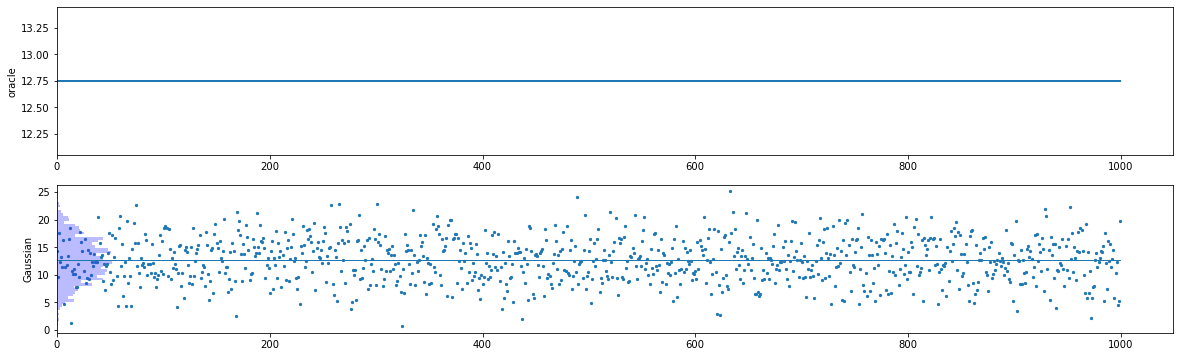

In [6]:
gaussian.plot_components()

In [7]:
%%runwrite -a ../timegym/data/synthetic.py

uniform = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    range = rcp.RandomUniform(0.01, 10, shape=1),
    oracle = rcp.RandomUniform(-100, 100, shape=1),
    Uniform = rcp.RandomUniform(rcp.Ref('oracle')-rcp.Ref('range'), 
                                rcp.Ref('oracle')+rcp.Ref('range'))
)

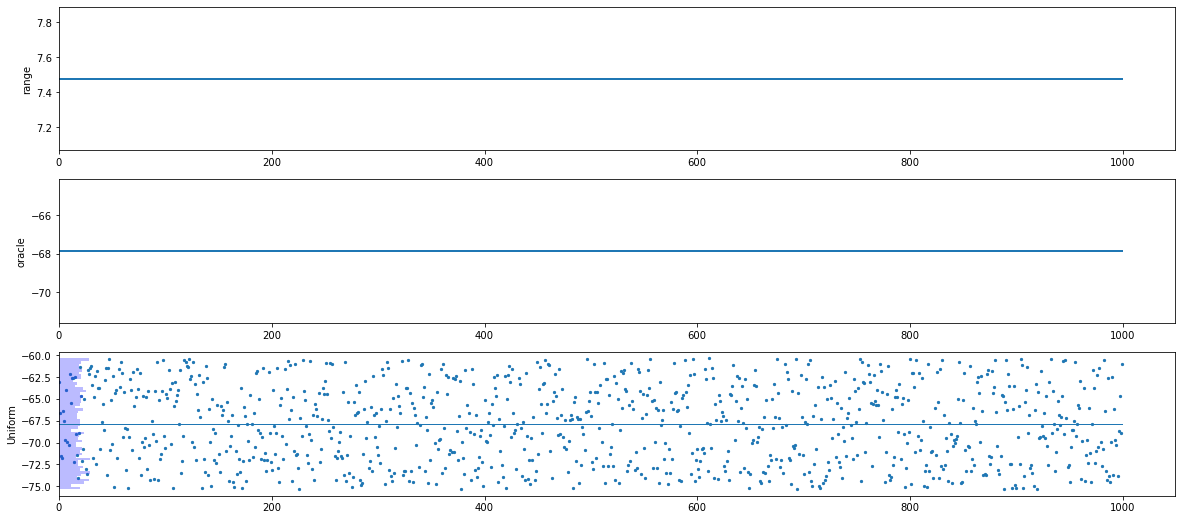

In [8]:
uniform.plot_components();

In [9]:
%%runwrite -a ../timegym/data/synthetic.py

symdirichlet = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    intercept = rcp.RandomUniform(-100, 100, shape=1),
    alpha = rcp.RandomUniform(0.01, 100, shape=1),
    oracle = rcp.Add([1/300, 'intercept']), # 1/lengh
    SymmetricDirichlet = rcp.RandomSymmetricDirichlet('alpha') + 'intercept'
)

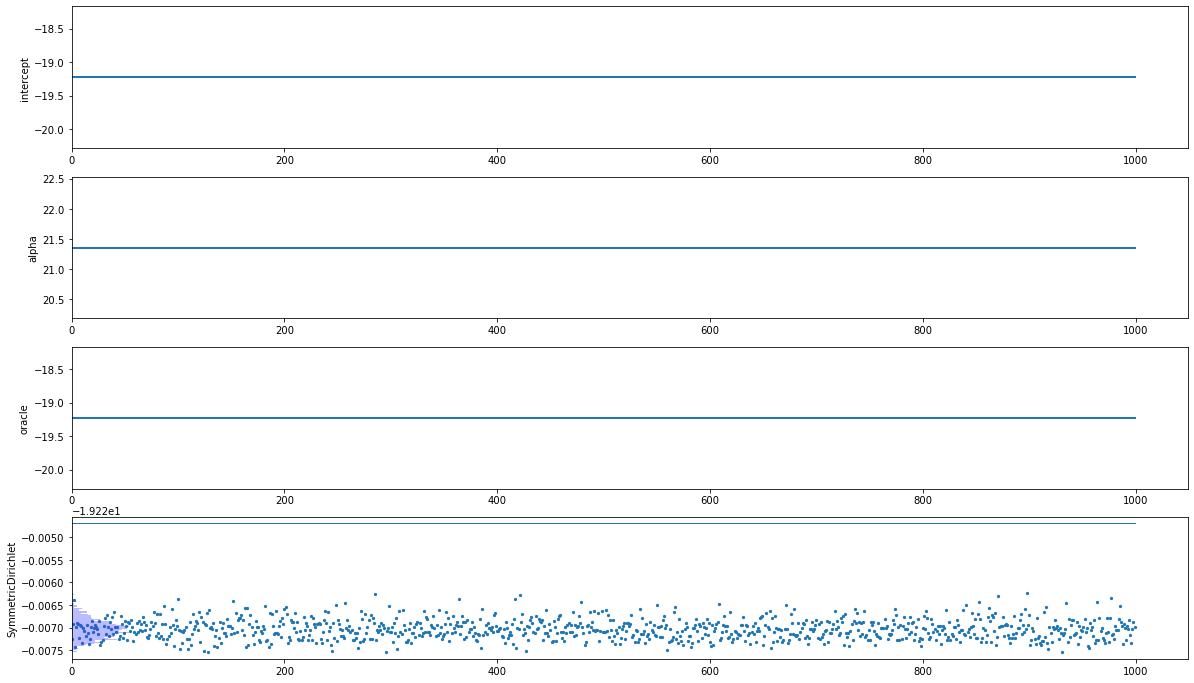

In [10]:
symdirichlet.plot_components();

## Geometric Brownian Motion


Yearly stock returns, for example, are often considered as log-normal distributed.

> If the random variable X is log-normally distributed, then Y = ln(X) has a normal distribution. - http://people.duke.edu/~hpgavin/cee201/ProbabilityDistributions.pdf

We can model this using 

In [1]:
import pandas as pd
import numpy as np

In [2]:
mean = 0.08# np.random.exponential(0.01)
std = mean**np.random.uniform(0.3, 0.7)
n = 5000000
mean, std, n

(0.08, 0.20375752449306408, 5000000)

In [8]:
normal_distribution = pd.Series(np.random.normal(mean, std, n))
lognormal_distribution = pd.Series(np.random.lognormal(mean, std, n))

Lognormal should have been called expnormal, because it is the result of applying exp to a normal distribution!

<AxesSubplot:ylabel='Frequency'>

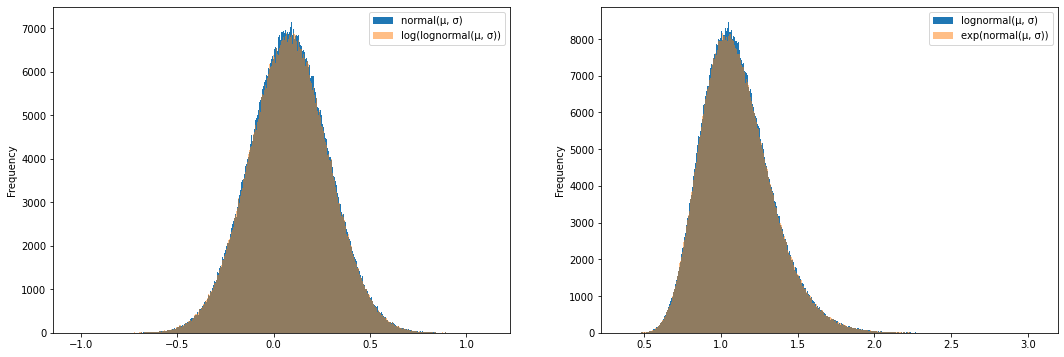

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(18,6))
normal_distribution.plot.hist(bins=3000, ax=axes[0], legend=True, label='normal(μ, σ)')
lognormal_distribution.apply(np.log).plot.hist(bins=3000, ax=axes[0], alpha=0.5, legend=True, label='log(lognormal(μ, σ))')
lognormal_distribution.plot.hist(bins=3000, ax=axes[1], legend=True, label='lognormal(μ, σ)');
normal_distribution.apply(np.exp).plot.hist(bins=3000, ax=axes[1], alpha=0.5, legend=True, label='exp(normal(μ, σ))')

In [16]:
%%runwrite -a ../timegym/data/synthetic.py

class GeometricBrownianMotion(SyntheticSeries):    
    def __init__(self, length, test_size):
        super().__init__(length, test_size, 'Brownian Motion')
        
    def generate_components(self):
        # define initial value of time series
        initial = np.random.exponential(1000)
        # define mean and std of underlying normal distributiion
        mean = np.random.exponential(0.0005)
        std = np.random.uniform(0.01, 0.03)
        
        # x[t] = x[t-1] * lognormal(mean, std)
        # returns are said to be log-normally distributed.
        # this means that the latent variable (also known as noise during simulation) 
        # is normally distributed, but suffers an exp() transformation applied to it.
        #factor = np.exp(np.cumsum(np.log(np.random.lognormal(mean, std, self.length))))
        #factor = np.exp(np.cumsum(np.log(np.exp(np.random.normal(mean, std, self.length)))))
        series = initial * np.exp(np.cumsum(np.random.normal(mean, std, self.length)))
        
        #oracle = np.empty(shape=self.length)
        #oracle[1:] = series[:-1] * np.exp(mean)
        #oracle[0] = np.nan
        oracle = initial * np.exp(np.arange(self.length) * mean)
        
        return pd.DataFrame({'oracle': oracle, self.shortname: series})

brownian = GeometricBrownianMotion(length=1000, test_size=300)

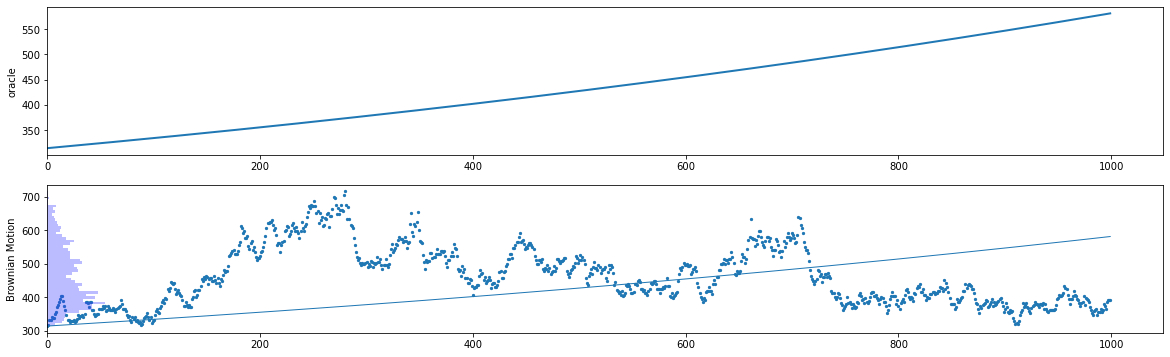

In [17]:
brownian.plot_components(oracle_on_target=True);

Are log-returns best modeled by normal distributions?

## Trend

In [18]:
%%runwrite -a ../timegym/data/synthetic.py

trend_clean = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    oracle = rcp.LinearTrend(slope=rcp.RandomUniform(2, 10, shape=1)),
    Trend = 'oracle'
)

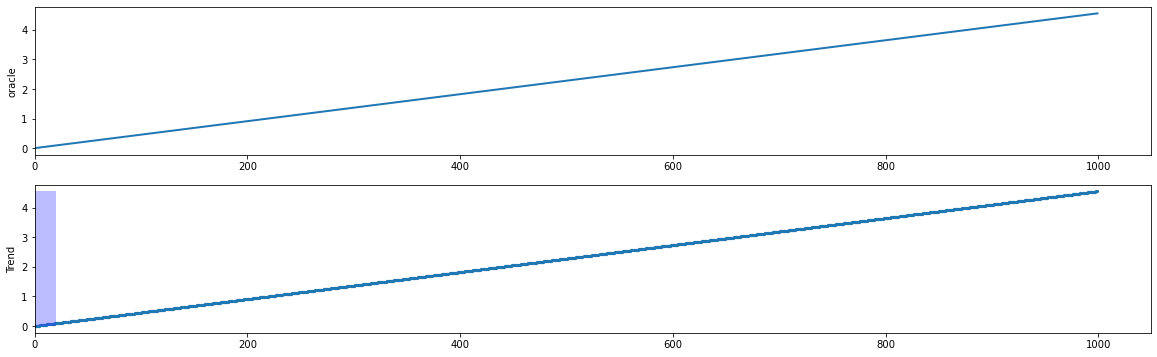

In [19]:
trend_clean.plot_components(oracle_on_target=False);

In [20]:
%%runwrite -a ../timegym/data/synthetic.py

trend_small_noise = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    noise = rcp.RandomGaussian(stddev=rcp.RandomUniform(0.5, 1, shape=1)),
    oracle = rcp.LinearTrend(slope=rcp.RandomUniform(3, 10, shape=1)),
    Trend = rcp.Add(['oracle','noise'])
)

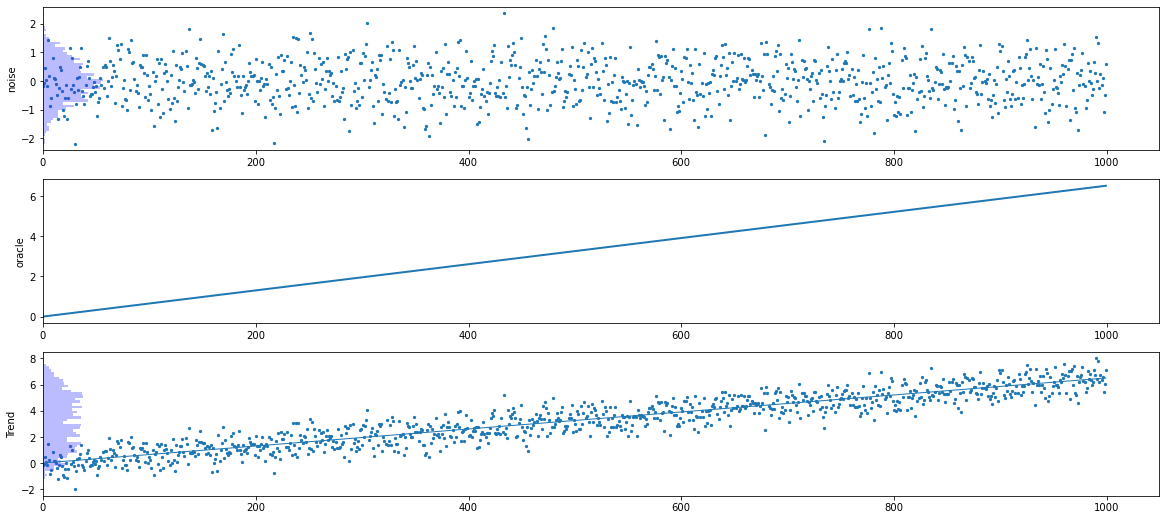

In [21]:
trend_small_noise.plot_components();

In [22]:
%%runwrite -a ../timegym/data/synthetic.py

trend_big_noise = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    noise = rcp.RandomGaussian(stddev=rcp.RandomUniform(3, 5, shape=1)),
    oracle = rcp.LinearTrend(slope=rcp.RandomUniform(3, 10, shape=1)),
    Trend = rcp.Add(['oracle','noise'])
)

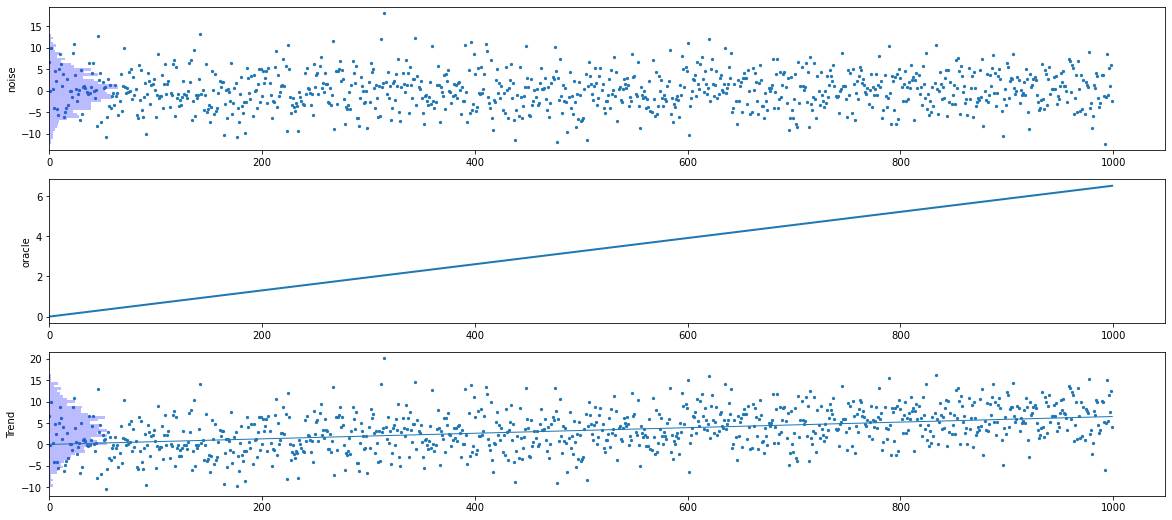

In [23]:
trend_big_noise.plot_components();

## Seasonality

In [24]:
%%runwrite -a ../timegym/data/synthetic.py

seasonality = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    oracle = rcp.SmoothSeasonality(period=rcp.RandomUniform(20, 100, shape=1), phase=0),
    Seasonality = 'oracle'
)

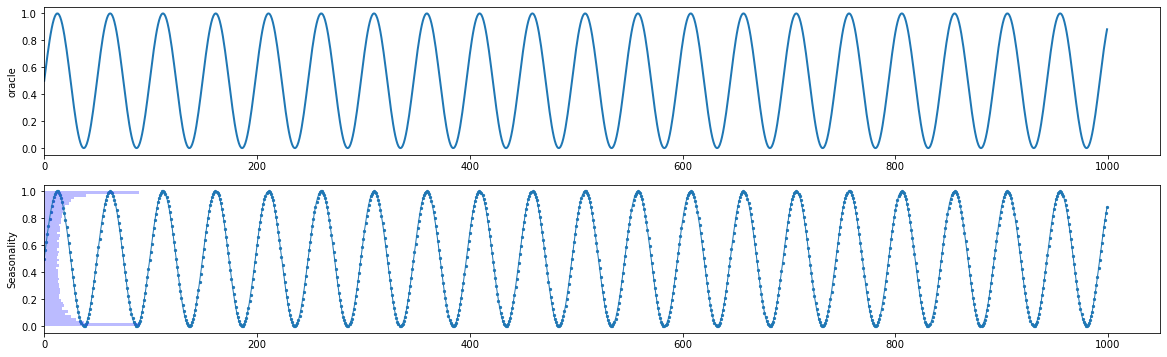

In [25]:
seasonality.plot_components();

In [26]:
%%runwrite -a ../timegym/data/synthetic.py

two_seasonalities = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    seasonality1 = rcp.SmoothSeasonality(period=rcp.RandomUniform(20, 100, shape=1), phase=0),
    seasonality2 = rcp.SmoothSeasonality(period=rcp.RandomUniform(100, 200, shape=1), phase=0),
    oracle = rcp.Add(['seasonality1','seasonality2']),
    TwoSeasonalities = 'oracle'
)

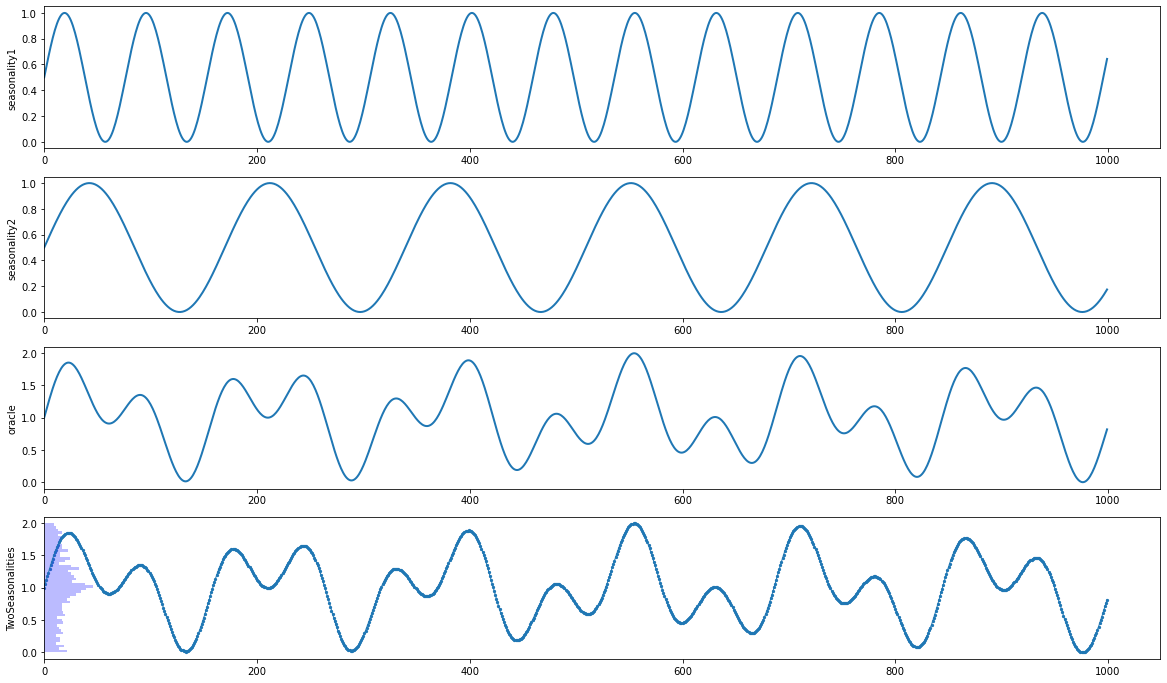

In [27]:
two_seasonalities.plot_components();

In [28]:
%%runwrite -a ../timegym/data/synthetic.py

seasonality_noisy = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    oracle = rcp.SmoothSeasonality(period=rcp.RandomUniform(20, 200, shape=1), phase=0),
    noise = rcp.RandomGaussian(stddev=rcp.RandomUniform(0.1, 0.8, shape=1)),
    SeasonalityNoisy = rcp.Add(['oracle', 'noise'])
)

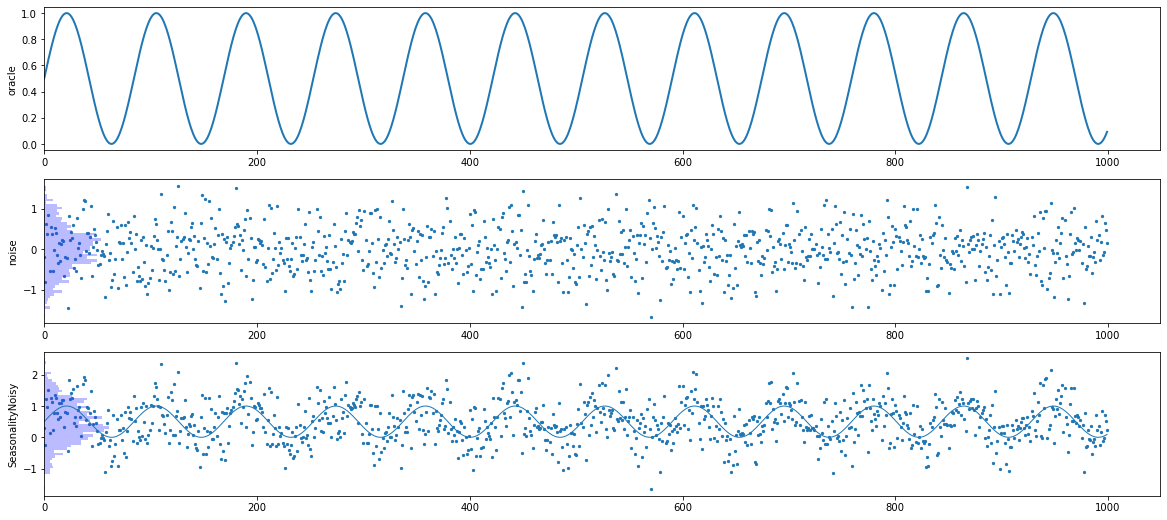

In [29]:
seasonality_noisy.plot_components();

In [30]:
%%runwrite -a ../timegym/data/synthetic.py

two_seasonalities_noisy = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    seasonality1 = rcp.SmoothSeasonality(period=rcp.RandomUniform(20, 100, shape=1), phase=0),
    seasonality2 = rcp.SmoothSeasonality(period=rcp.RandomUniform(100, 200, shape=1), phase=0),
    oracle = rcp.Add(['seasonality1','seasonality2']),
    noise = rcp.RandomGaussian(stddev=rcp.RandomUniform(0.1, 0.8, shape=1)),
    TwoSeasonalitiesNoisy = rcp.Add(['oracle', 'noise'])
)

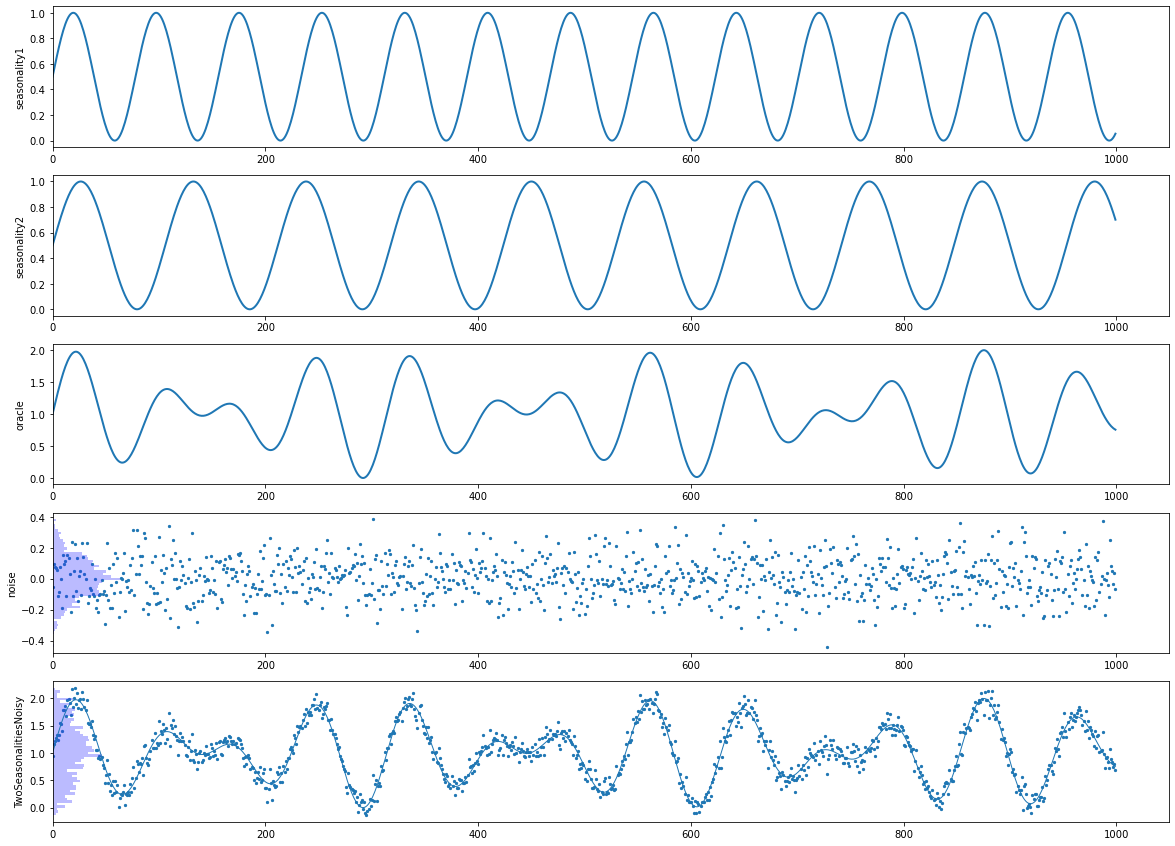

In [31]:
two_seasonalities_noisy.plot_components();

## Trend + Seasonality

In [32]:
%%runwrite -a ../timegym/data/synthetic.py

trend_seasonality = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    trend = rcp.LinearTrend(slope=rcp.RandomUniform(1, 10, shape=1)),
    seasonality = rcp.SmoothSeasonality(period=rcp.RandomUniform(10, 200, shape=1), phase=0),
    oracle = rcp.Add(['trend', 'seasonality']),
    TrendSeasonality = 'oracle'
)

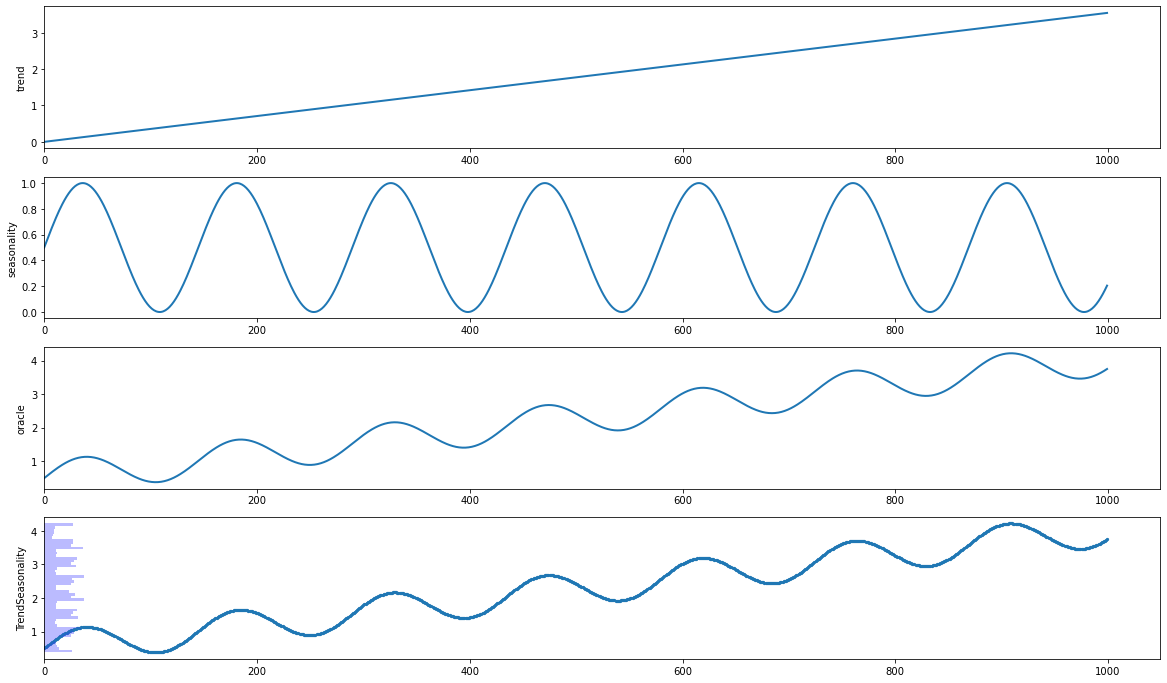

In [33]:
trend_seasonality.plot_components();

## Yearly Seasonality


In [ ]:
# TODO some months typically being systematically higher/lower

## Weekly patterns

In [34]:
%%runwrite -a ../timegym/data/synthetic.py

class WeeklySyntheticSeries(SyntheticSeries):  
    def __init__(self, length, test_size):
        super().__init__(length, test_size, 'Weekly Patterns')
        
    def generate_components(self):
        # define mean and std to reasonable values
        mean1 = np.random.exponential(10)
        std1 = mean1**np.random.uniform(0.1, 0.4)
        weekdays = np.random.normal(mean1, std1, size=self.length)
        
        mean2 = np.random.exponential(10)
        std2 = mean2**np.random.uniform(0.1, 0.4)
        weekends = np.random.normal(mean2, std2, size=self.length)

        week_pattern = np.resize([1, 1, 1, 1, 1, 0, 0], self.length)
        timeseries = weekdays*week_pattern + weekends*(1-week_pattern)
        oracle = mean1*week_pattern + mean2*(1-week_pattern)
        
        return pd.DataFrame({
            'weekdays': weekdays,
            'weekends': weekends,
            'oracle': oracle,
            self.shortname: timeseries
        })

weekdays = WeeklySyntheticSeries(length=300, test_size=30)

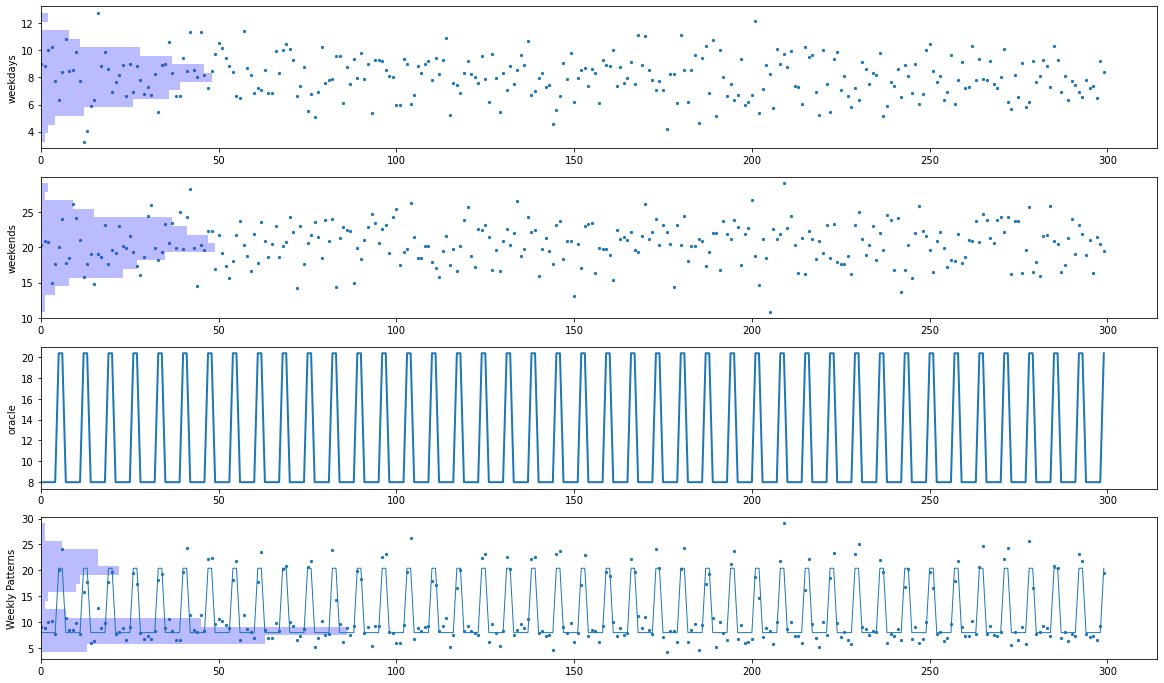

In [35]:
weekdays.plot_components(scatter_components=['target', 'weekdays', 'weekends'],
                         histogram_components=['target', 'weekdays', 'weekends']);

## Anomalies / Outliers

In [36]:
%%runwrite -a ../timegym/data/synthetic.py

anomalies = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    trend = rcp.LinearTrend(slope=2),
    seasonality = rcp.SmoothSeasonality(period=250, phase=0),
    noise = rcp.RandomGaussian(stddev=0.4),
    anomalies = rcp.RandomUniform(2, 4) * rcp.RandomGaussian() * rcp.RandomBinary(prob=0.01),
    oracle = rcp.Add(['trend', 'seasonality']),
    TrendSeasonalityAnomalies = rcp.Add(['trend', 'seasonality', 'noise', 'anomalies'])
)

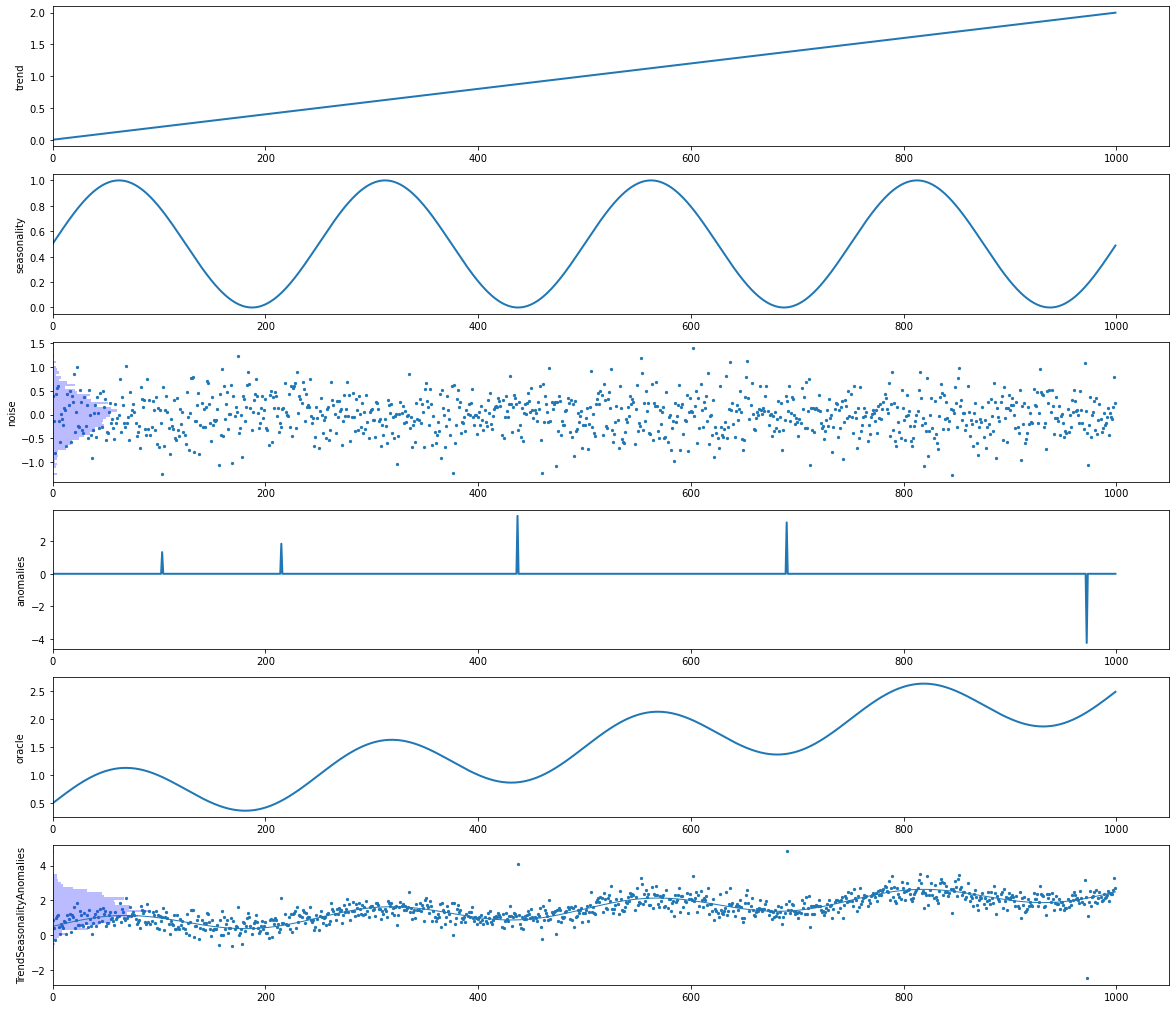

In [37]:
anomalies.plot_components();

## Concept Drift

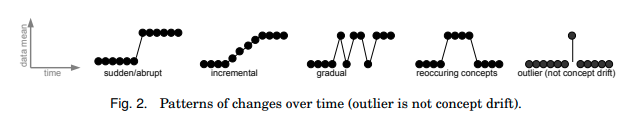

Source: [A survey on concept drift adaptation (Gama et al, 2014)](http://www.liaad.up.pt/area/jgama/reviewCD_methods.pdf)

So far, we've modelered reoccuring concepts.

Reoccuring concepts are similar to gradual concepts.

Let's model these 

TODO:

* add incremental concept drift
* add sudden / abrupt drift
* add intermittent concept drift *
* add to references 

TODO:

* add concept drift applied to std!
* other types of drift
* Yassine's concept glitch

### Recurrent Concept Drift

In [38]:
%%runwrite -a ../timegym/data/synthetic.py

two_markov = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    oracle = rcp.BinaryMarkovChain(0.01, 0.01) * rcp.RandomUniform(8, 15, shape=1),
    TwoMarkovStates = 'oracle'
)

In [39]:
two_markov.get_data()

(0      11.881623
 1      11.881623
 2      11.881623
 3      11.881623
 4      11.881623
          ...    
 695    11.881623
 696    11.881623
 697    11.881623
 698    11.881623
 699    11.881623
 Name: TwoMarkovStates, Length: 700, dtype: float64,
 700    11.881623
 701    11.881623
 702    11.881623
 703    11.881623
 704    11.881623
          ...    
 995     0.000000
 996     0.000000
 997     0.000000
 998     0.000000
 999     0.000000
 Name: TwoMarkovStates, Length: 300, dtype: float64,
 0      11.881623
 1      11.881623
 2      11.881623
 3      11.881623
 4      11.881623
          ...    
 995     0.000000
 996     0.000000
 997     0.000000
 998     0.000000
 999     0.000000
 Name: oracle, Length: 1000, dtype: float64)

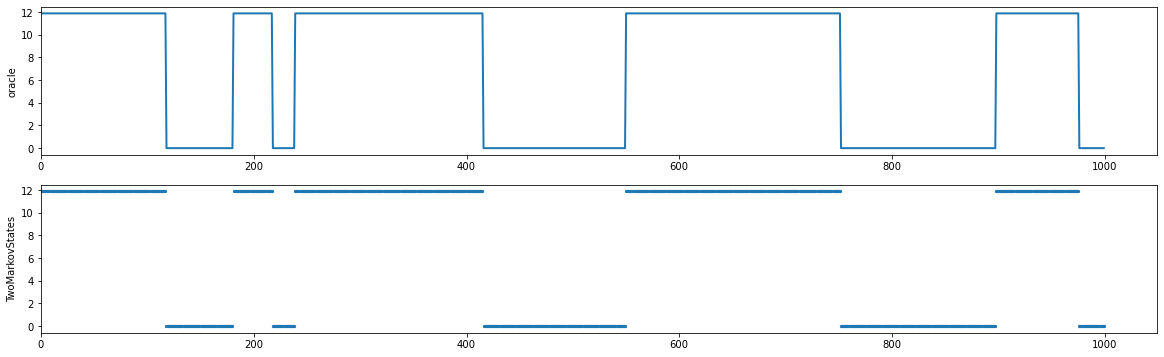

In [40]:
two_markov.plot_components(oracle_on_target=False, histogram_components=[]);

In [41]:
%%runwrite -a ../timegym/data/synthetic.py

two_markov_fast = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    oracle = rcp.BinaryMarkovChain(0.1, 0.1) * rcp.RandomUniform(8, 15, shape=1),
    TwoMarkovStatesFast = 'oracle'
)

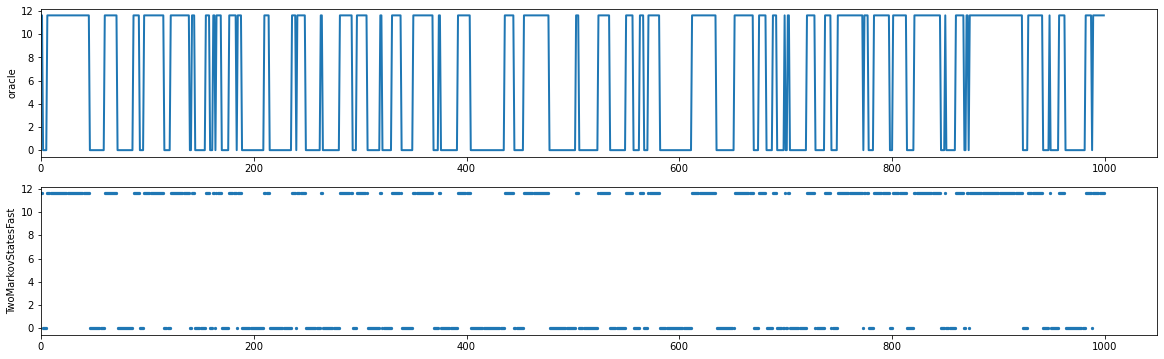

In [42]:
two_markov_fast.plot_components(oracle_on_target=False, histogram_components=[]);

In [43]:
%%runwrite -a ../timegym/data/synthetic.py

two_gaussians = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    oracle = rcp.BinaryMarkovChain(0.5, 0.5) * rcp.RandomUniform(5, 10, shape=1),
    TwoGaussians = rcp.RandomGaussian(stddev=rcp.RandomUniform(0.1, 2, shape=1)) + 'oracle'
)

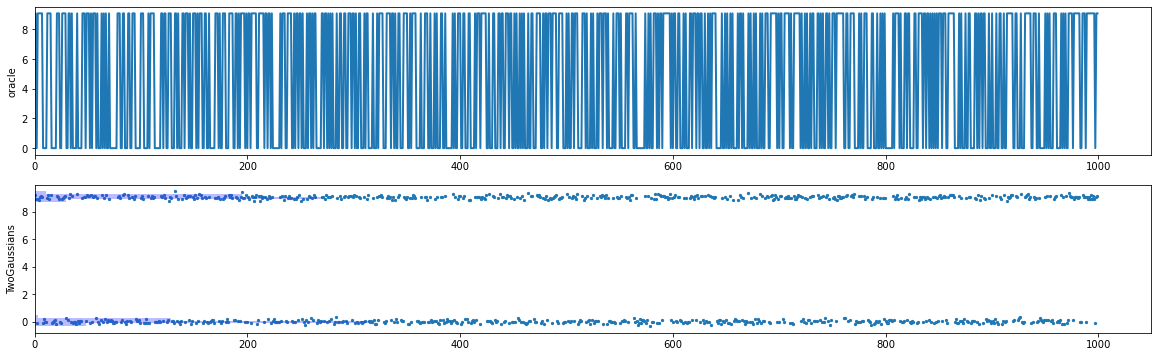

In [44]:
two_gaussians.plot_components(oracle_on_target=False);

In [45]:
%%runwrite -a ../timegym/data/synthetic.py

two_gaussians_imbalanced = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    oracle = rcp.BinaryMarkovChain(0.3, 0.7) * rcp.RandomUniform(8, 15, shape=1),
    TwoGaussiansImbalanced = rcp.RandomGaussian(stddev=rcp.RandomUniform(1, 3, shape=1)) + 'oracle'
)

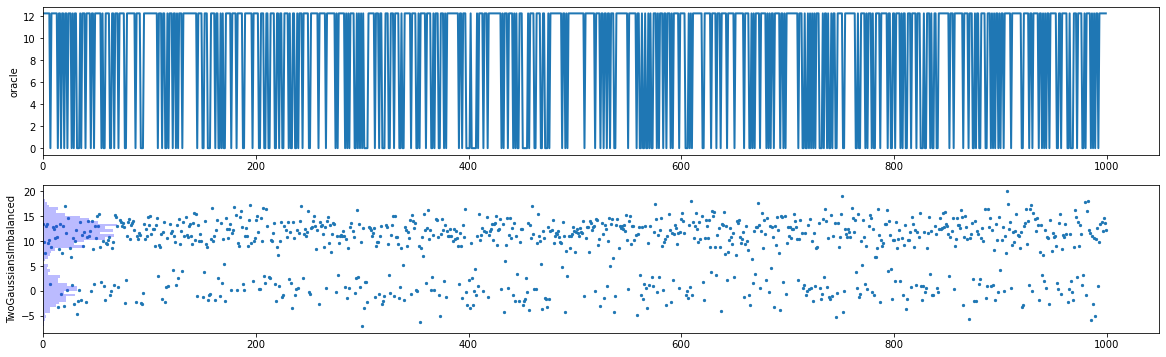

In [46]:
two_gaussians_imbalanced.plot_components(oracle_on_target=False);

In [47]:
%%runwrite -a ../timegym/data/synthetic.py

two_gaussians_markov = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    oracle = rcp.BinaryMarkovChain(0.05, 0.1) * rcp.RandomUniform(8, 15, shape=1),
    TwoGaussianMarkov = rcp.RandomGaussian(stddev=rcp.RandomUniform(1, 3, shape=1)) + 'oracle'
)

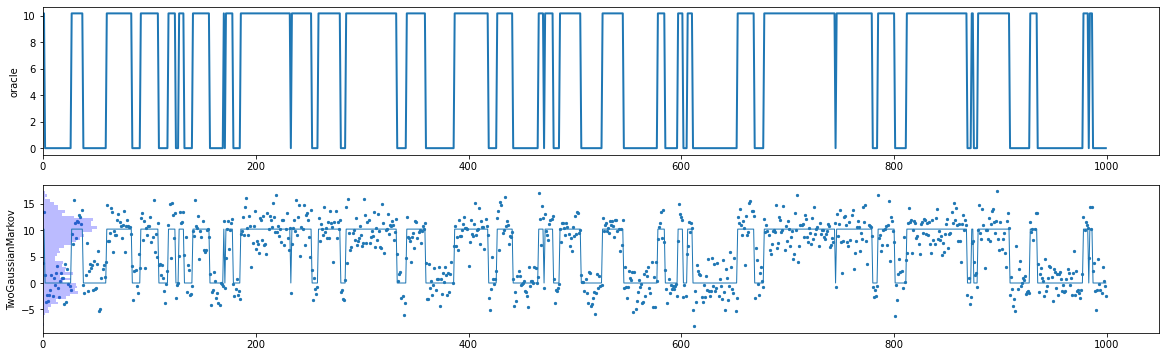

In [48]:
two_gaussians_markov.plot_components();

In [49]:
%%runwrite -a ../timegym/data/synthetic.py

#class ConceptDriftChallenges(CompositeChallenges):
#    
#    def __init__(self, challenge1, challenge2, drift_probability):
#        """
#        Simulates the effect of recurrent concept drift by using a markov chain that changes between challenges.
#        The initializer takes a list drift_probability, that represents the probability of drifting from challenges.
#        """
#        assert len(challeges) == len(drift_probability)
#
#    
#class AverageDriftChallenges(CompositeChallenges):
#    
#    def __init__(self, challenges, weights, activate_probability, deactivate_probability):
#        """
#        Simulates the effect of averaging several challenges that may or may not be active at a certain time.
#        activate_probability represents the probabilities of challenges becoming active.
#        deactivate_probability represents the probabilities of challenges becoming innactive.
#        """
#        assert len(challeges) == len(weights) == len(activate_probability) == len(deactivate_probability)
#        
#class MetaChallenges:
#    weights are dynamic, they change between 0 to 1 like timeseries, some of them are binary, others are smooth.
#    The weights themselves are time series that we wish to predict.
#    

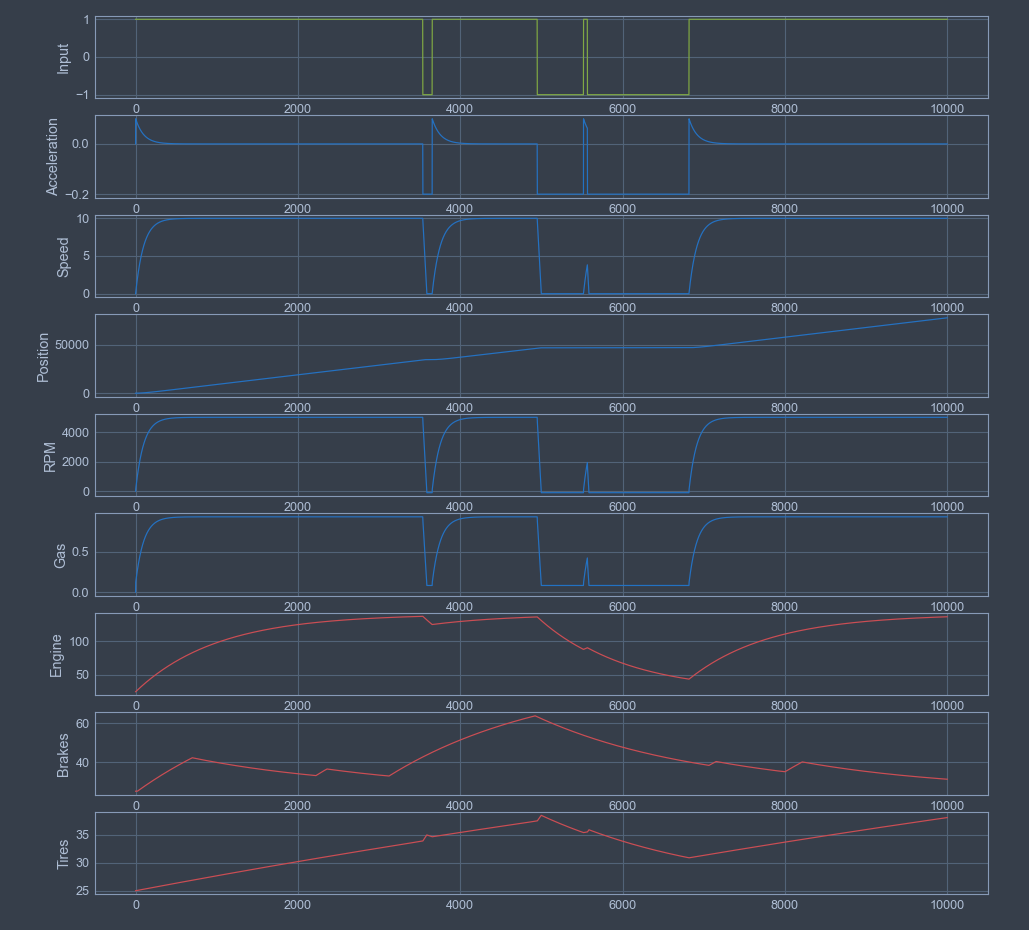

## Frequency Domain

In [50]:
# TODO fft

In [51]:
# TODO spectral analysis

In [52]:
# TODO wavelets

## Anomalies

In [ ]:
# TODO strange anomalies

## Splines

In [1]:
# TODO the inputs define the points which define the spline

## Composite

In [53]:
%%runwrite -a ../timegym/data/synthetic.py

class AverageSyntheticSeries(SyntheticSeries):
    
    def __init__(self, synthetic_series, weights):
        """
        Weighted average of the timeseries of many synthetic_series.
        """
        assert len(synthetic_series) == len(weights)
        for i in range(1, len(synthetic_series)):
            assert synthetic_series[0].length == synthetic_series[i].length
            assert synthetic_series[0].test_size == synthetic_series[i].test_size
        self.synthetic_series = synthetic_series
        self.weights = weights
        
        super().__init__(synthetic_series[0].length, synthetic_series[0].test_size)
        # TODO check that the lengths and test_sizes are the same
        # if no check, simply increase it to the proportion of time series 1
    
    def generate_components(self):
        oracles = []
        targets = []
        components = []
        
        for i, challenge in enumerate(self.synthetic_series): 
            challenge_components = challenge.generate_components()
            oracles += [challenge_components['oracle'] * self.weights[i]]
            targets += [challenge_components[challenge.target] * self.weights[i]]
            components += [challenge_components.rename(columns={'oracle':'oracle#C'+str(i)})]
        
        components = pd.concat(components, axis=1)
        components['oracle'] = pd.concat(oracles, axis=1).sum(axis=1) / sum(self.weights)
        components['Composite Target'] = pd.concat(targets, axis=1).sum(axis=1) / sum(self.weights)
        
        return components
          

In [54]:
%%runwrite -a ../timegym/data/synthetic.py

average = AverageSyntheticSeries(
    [trend_clean, two_seasonalities, two_gaussians_markov],
    [5, 3, 2]
)

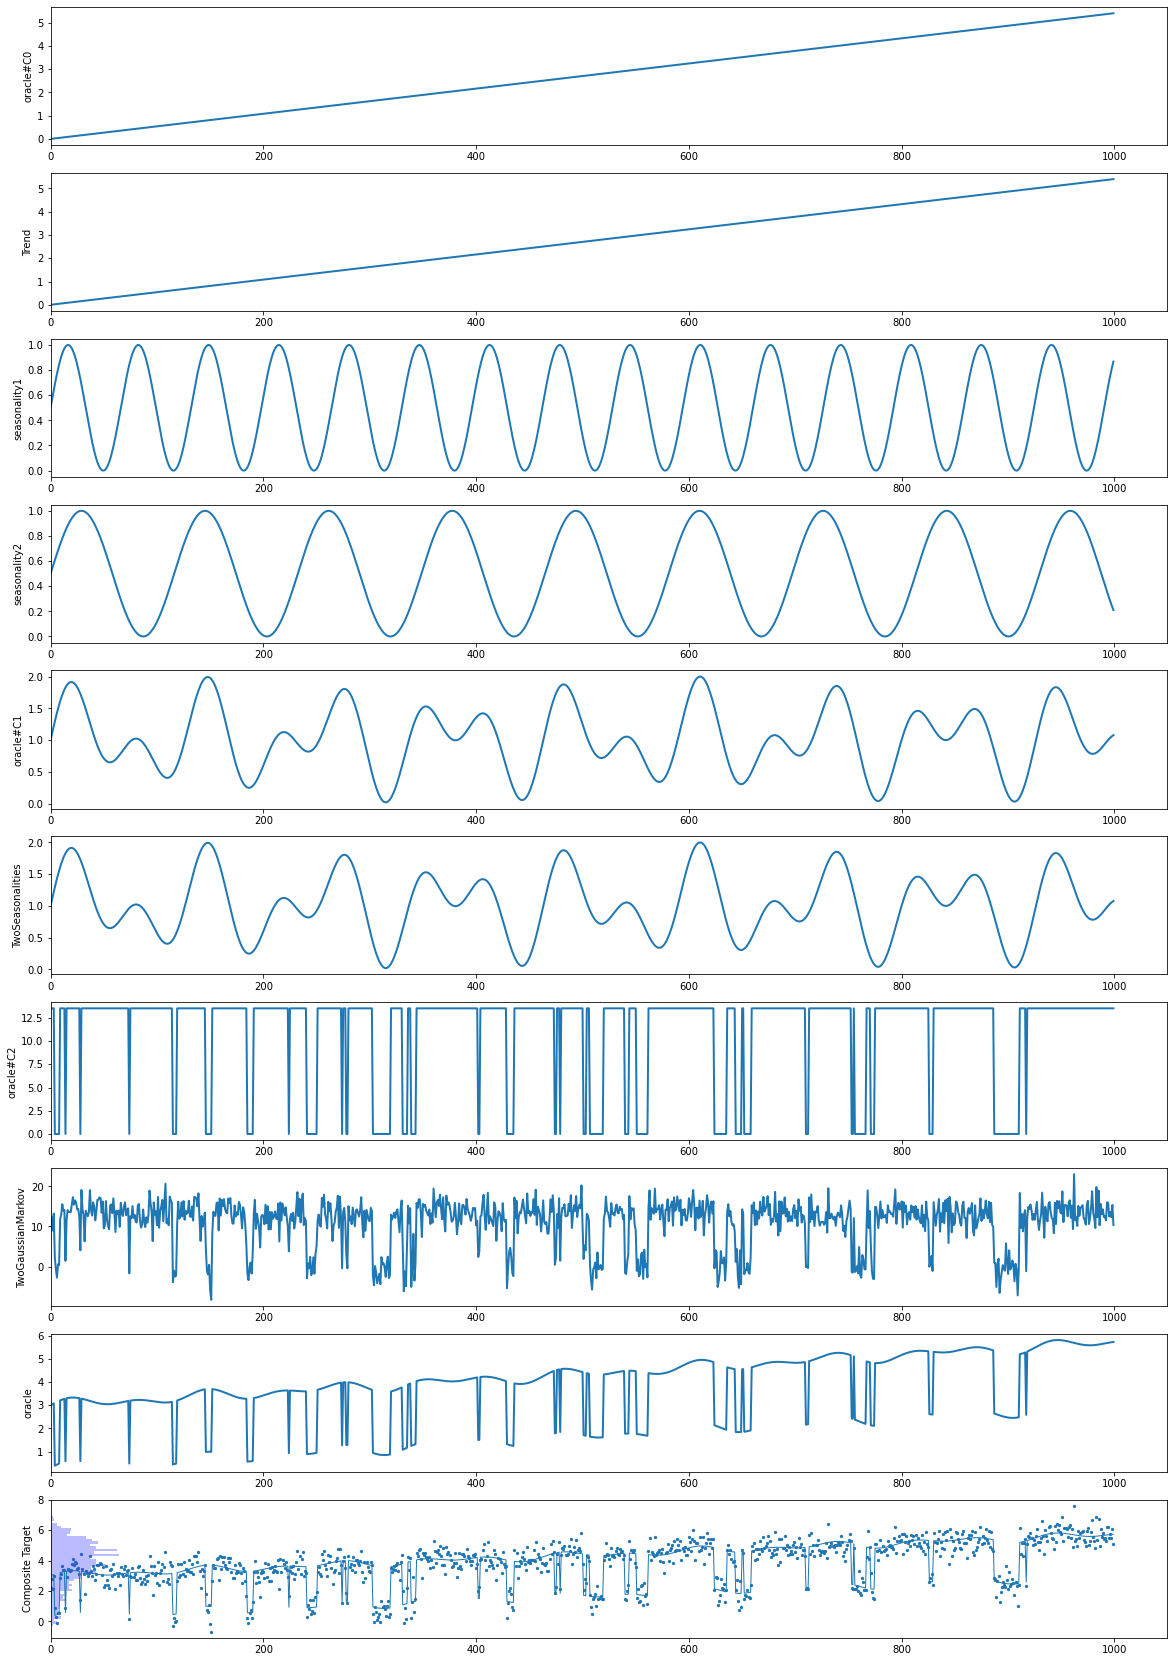

In [55]:
average.plot_components(oracle_on_target=True);

# Synthetic Test Suite

## Basic synthetic series

In [56]:
%%runwrite -a ../timegym/data/synthetic.py

basic_synthetics = [
    gaussian,
    uniform,
    trend_clean,
    trend_small_noise,
    trend_big_noise,
    seasonality,
    seasonality_noisy,
    two_seasonalities_noisy,
    trend_seasonality,
    anomalies,
    weekdays
]

## Extended synthetic series

In [57]:
%%runwrite -a ../timegym/data/synthetic.py

extended_synthetics = [
    gaussian,
    uniform,
    symdirichlet,
    two_markov,
    two_markov_fast,
    two_gaussians,
    two_gaussians_imbalanced,
    two_gaussians_markov,
    trend_clean,
    trend_small_noise,
    trend_big_noise,
    seasonality,
    two_seasonalities,
    seasonality_noisy,
    two_seasonalities_noisy,
    trend_seasonality,
    weekdays,
    anomalies
]

## More cases

In [ ]:
# TODO: include these cases

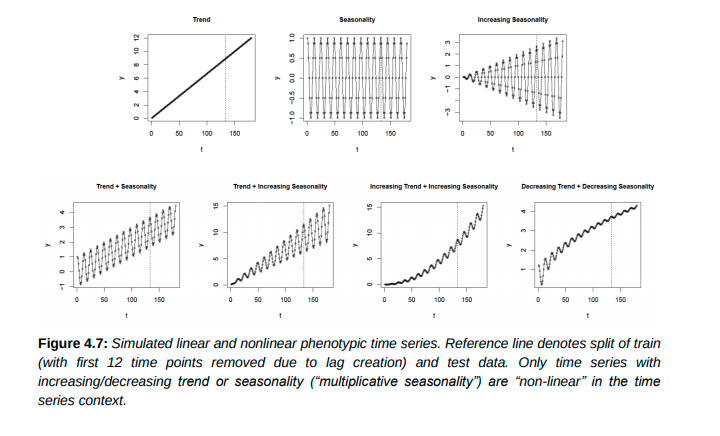

In [ ]:
# TODO add data repetition

In [ ]:
# TODO label error

In [ ]:
# TODO data missing

In [ ]:
# TODO data shuffle

In [ ]:
# TODO noise perturbation

In [ ]:
# .how_much_data() → how much data does the method need to converge to optimal solution?

In [ ]:
#    + * / - operators for data.synthetics

In [ ]:
# TODO signal-to-noise ratio (actual vs predicted)